In [57]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
from ocp_table_tpot.globals import Globals as gd
from tpot import TPOTRegressor
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase,TimeSeriesSplitImproved
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,RANSACRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PolynomialFeatures,QuantileTransformer,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split,cross_val_predict
from skgarden.quantile import RandomForestQuantileRegressor
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from copy import copy
from tpot.builtins import StackingEstimator
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline, make_union
from catboost import CatBoostRegressor,Pool,cv
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase

class RegressorWrapper(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator, verbose=None, fit_params=None, use_proba=False, scoring=None):
        self.estimator = estimator
        self.verbose = verbose #True = 1, False = 0, 1 - moderately verbose, 2- extra verbose    
        if verbose is None:
            self.verbose=0
        else:
            self.verbose=verbose
        self.fit_params= fit_params
        self.use_proba = use_proba #whether to use predict_proba in transform
        self.scoring = scoring # calculate validation score, takes score function name
        #TODO check if scorer imported?
        self.score = None #variable to keep the score if scoring is set.

    def fit(self,X,y):
        fp=self.fit_params
        if self.verbose==2: print("X: ", X.shape, "\nFit params:", self.fit_params)
        
        if fp is not None:
            self.estimator.fit(X,y, **fp)
        else:
            self.estimator.fit(X,y)
        
        return self
    
    def transform(self, X):
        if self.use_proba:
            pred = self.estimator.predict_proba(X).reshape(-1,1)
            return np.vstack([X,pred])
        else:
            pred = self.estimator.predict(X).reshape(-1,1)
            return np.hstack([X,pred])
    
    def fit_transform(self,X,y,**kwargs):
        self.fit(X,y)
        p = self.transform(X)
        if self.scoring is not None:
            self.score = eval(self.scoring+"(y,p)")
            #TODO print own instance name?
            if self.verbose >0: print("score: ", self.score) 
        return p
    
    def predict(self,X):
        return self.estimator.predict(X)
    
    def predict_proba(self,X):
        return self.estimator.predict_proba(X)

## Load data

In [58]:
df_tsfresh = pd.read_pickle(f'../data/processed/train_test_tsfresh.pkl').reset_index(level = 0)
data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')

#df_flat = df_tsfresh.pivot(df_tsfresh)
#df_flat.columns = ['_'.join(col).strip() for col in df_flat.columns.values]


# Build a ML model


## Try to build an encoder for few most important features

In [59]:
# For Rougher 
tgt = 'rougher.output.recovery'

year = 2019
X = data_dict[year]['X_train_ts']
y = data_dict[year]['y_train']
inds_y = y[(y[tgt] > 0) & (y[tgt] < 100)].index
inds_common = inds_y
X = X.loc[inds_common,].filter(regex=r'rougher',axis=1)
y = y.loc[inds_common, tgt]
#X = X.sample(frac=0.4,random_state=123).sort_index().dropna()
y= y[X.index]
y.shape

C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(13961,)

In [64]:
# For Final 
tgt = 'final.output.recovery'

year = 2019
X = data_dict[year]['X_train_ts']
y = data_dict[year]['y_train']
inds_y = y[(y[tgt] > 31) & (y[tgt] < 100)].index
inds_common = X.index.intersection(inds_y)
X = X.loc[inds_common,]
y = y.loc[inds_common, tgt]
X = X.dropna()
y= y[X.index]
X_alt = X.loc[:,~X.columns.str.contains('rougher')]
#X_alt.columns.tolist()
#X.columns.contains('rougher')


In [67]:
from sklearn.ensemble import IsolationForest

params_xg =  {'max_depth': 3, 'gamma': '0.544', 'colsample_bytree': '0.684', 'subsample': '0.932'}

model_xgb = xgb.XGBRegressor(learning_rate=0.1,  
                             n_estimators=200,                        
                             random_state =7, nthread = -1,**params_xg)

irf= IsolationForest()
model_lgb = lgb.LGBMRegressor(objective='huber',
                              learning_rate=0.07, n_estimators=500,random_state=9,
                              **{'max_depth': 5, 'num_leaves': 65, 'feature_fraction': '0.879', 'bagging_fraction': '0.727'})
scaler = make_pipeline(QuantileTransformer(output_distribution='normal'),StandardScaler(),PCA(whiten=True))

model_lgb_sc = make_pipeline(scaler,model_lgb)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1,max_iter = 2000))
lasso_sc = make_pipeline(scaler, Lasso(alpha =0.005, random_state=1,max_iter = 2000))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.01, l1_ratio=.9, random_state=3))
CatBoost = CatBoostRegressor(loss_function='MAE',random_seed =123,eta=0.2,max_depth=8,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 1000)


n_folds =8
def rmsle_cv_gen_compare(model,cv = None,plot = False,X_base=None,X_alt = None,y=None,catboost = False):
    if cv is None:
        cv = KFold(n_folds, shuffle=False, random_state=42)
    scores = []
    preds_all_alt = np.empty_like(y)
    preds_all_base = np.empty_like(y)
    
    true_all =np.empty_like(y)
    if plot:
        fig,ax = plt.subplots(figsize = (20,16),nrows = n_folds)
    for fold_n, (train_index, valid_index) in enumerate(cv.split(X)):
    # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        X_train_alt, X_valid_alt = X_alt.iloc[train_index], X_alt.iloc[valid_index]
        
        print(y.shape)
        # Do the base
        if not catboost:
            model.fit(X_train.values,y_train.values.reshape(-1,))
        else:
            model.fit(X_train.values,y_train.values.reshape(-1,),eval_set=(X_valid.values, y_valid.values.reshape(-1,)),plot=False,verbose_eval = 100)
                
        preds  = model.predict(X_valid.values)
        preds_all_base[valid_index] = preds
        score_val = mase(preds,y_valid)
        # Do the alternative
        model.fit(X_train_alt.values,y_train.values.reshape(-1,))
        preds_alt  = model.predict(X_valid_alt.values)
        score_val_alt = mase(preds_alt,y_valid)
        preds_all_alt[valid_index] = preds_alt
        # print(f'Fold {fold_n}. Score: {score_val:.4f}.')
        #print('')
        true_all[valid_index] = y_valid
        scores.append(score_val)
        if plot:
            df = pd.DataFrame({"preds":preds,"true":y_valid,"alter":preds_alt})
            df.plot(ax=ax[fold_n],style =['-o','-o','-o'],title =f'CV score base: {score_val:.4f}, alter: {score_val_alt:.4f}',markersize=2)
    
    #print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    oof_scores = {"base":mase(preds_all_base,true_all),"alter":mase(preds_all_alt,true_all),"index":y.index}
    print(oof_scores)
    if plot:
        return(ax,np.array(scores),oof_scores)
    else:
        return(np.array(scores),oof_scores)
def cv_oof(model,X_base=None,y=None,params = {}):
    cv = KFold(n_folds, shuffle=False, random_state=42)
    preds = cross_val_predict(model,X=X_base,y=y,cv=cv,n_jobs = 1,method = 'predict',fit_params = params)
    oof_scores = mase(preds,y)
    return oof_scores,preds

                          
        

(14682,)
(14682,)
(14682,)
(14682,)
(14682,)
(14682,)
(14682,)
(14682,)
{'base': 1.6315209451214154, 'alter': 1.762136039914935, 'index': DatetimeIndex(['2016-01-15 01:00:00+00:00', '2016-01-15 02:00:00+00:00',
               '2016-01-15 03:00:00+00:00', '2016-01-15 04:00:00+00:00',
               '2016-01-15 05:00:00+00:00', '2016-01-15 06:00:00+00:00',
               '2016-01-15 07:00:00+00:00', '2016-01-15 08:00:00+00:00',
               '2016-01-15 09:00:00+00:00', '2016-01-15 10:00:00+00:00',
               ...
               '2018-08-18 01:59:59+00:00', '2018-08-18 02:59:59+00:00',
               '2018-08-18 03:59:59+00:00', '2018-08-18 04:59:59+00:00',
               '2018-08-18 05:59:59+00:00', '2018-08-18 06:59:59+00:00',
               '2018-08-18 07:59:59+00:00', '2018-08-18 08:59:59+00:00',
               '2018-08-18 09:59:59+00:00', '2018-08-18 10:59:59+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=14682, freq=None)}


(array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026C84BFEF28>,
       dtype=object),
 array([1.58848291, 1.80076143, 1.55880744, 1.92161737, 1.92211203,
        1.55016623, 1.40120061, 1.43869457]),
 {'base': 1.6315209451214154,
  'alter': 1.762136039914935,
  'index': DatetimeIndex(['2016-01-15 01:00:00+00:00', '2016-01-15 02:00:00+00:00',
                 '2016-01-15 03:00:00+00:00', '2016-01-15 04:00:00+00:00',
                 '2016-01-15 05:00:00+00:00', '2016-01-15 06:00:00+00:00',
                 '2016-01-15 07:00:00+00:00', '2016-01-15 08:00:00+00:00',
                 '2016-01-15 09:00:00+00:00', '2016-01-15 10:00:00+00:00',
                 ...
                 '2018-08-18 01:59:59+00:00', '2018-08-18 02:59:59+00:00',
                 '2018-08-18 03:59:59+00:00', '2018-08-18 04:59:59+00:00',
                 '2018-08-18 05:59:59+00:00', '2018-08-18 06:59:59+00:00',
                 '2018-08-18 07:59:59+00:00', '2018-08-18 08:59:59+00:00',
                 '201

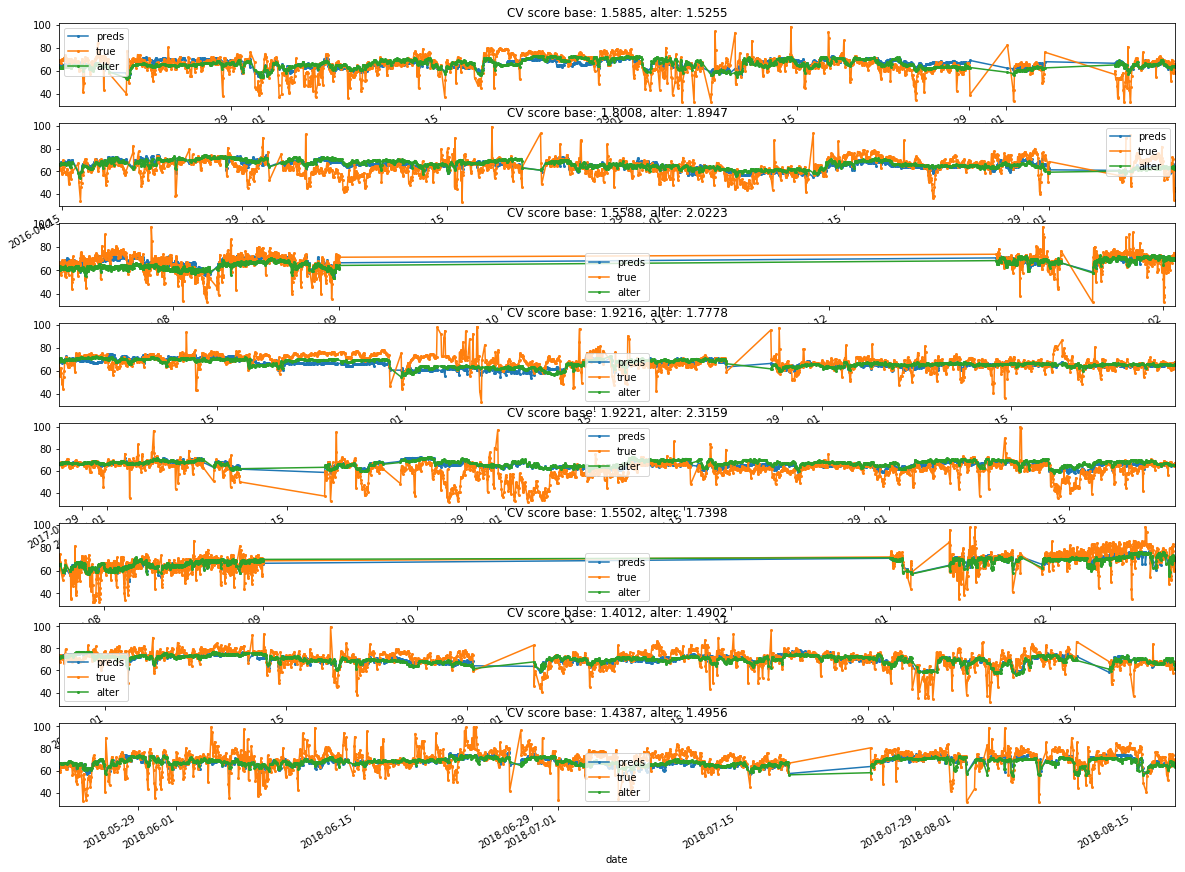

In [70]:
rmsle_cv_gen_compare(model_lgb,plot = True,X_base=X,X_alt = X_alt,y=y,catboost = False)

(14682,)
(14682,)
(14682,)
(14682,)
(14682,)
(14682,)
(14682,)
(14682,)
{'base': 1.7926900047938499, 'alter': 1.83256458790776, 'index': DatetimeIndex(['2016-01-15 01:00:00+00:00', '2016-01-15 02:00:00+00:00',
               '2016-01-15 03:00:00+00:00', '2016-01-15 04:00:00+00:00',
               '2016-01-15 05:00:00+00:00', '2016-01-15 06:00:00+00:00',
               '2016-01-15 07:00:00+00:00', '2016-01-15 08:00:00+00:00',
               '2016-01-15 09:00:00+00:00', '2016-01-15 10:00:00+00:00',
               ...
               '2018-08-18 01:59:59+00:00', '2018-08-18 02:59:59+00:00',
               '2018-08-18 03:59:59+00:00', '2018-08-18 04:59:59+00:00',
               '2018-08-18 05:59:59+00:00', '2018-08-18 06:59:59+00:00',
               '2018-08-18 07:59:59+00:00', '2018-08-18 08:59:59+00:00',
               '2018-08-18 09:59:59+00:00', '2018-08-18 10:59:59+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=14682, freq=None)}


(array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026C85BC43C8>,
       dtype=object),
 array([1.622947  , 1.90166194, 2.08610025, 1.85074491, 2.4237072 ,
        1.65202289, 1.43338658, 1.5508456 ]),
 {'base': 1.7926900047938499,
  'alter': 1.83256458790776,
  'index': DatetimeIndex(['2016-01-15 01:00:00+00:00', '2016-01-15 02:00:00+00:00',
                 '2016-01-15 03:00:00+00:00', '2016-01-15 04:00:00+00:00',
                 '2016-01-15 05:00:00+00:00', '2016-01-15 06:00:00+00:00',
                 '2016-01-15 07:00:00+00:00', '2016-01-15 08:00:00+00:00',
                 '2016-01-15 09:00:00+00:00', '2016-01-15 10:00:00+00:00',
                 ...
                 '2018-08-18 01:59:59+00:00', '2018-08-18 02:59:59+00:00',
                 '2018-08-18 03:59:59+00:00', '2018-08-18 04:59:59+00:00',
                 '2018-08-18 05:59:59+00:00', '2018-08-18 06:59:59+00:00',
                 '2018-08-18 07:59:59+00:00', '2018-08-18 08:59:59+00:00',
                 '2018

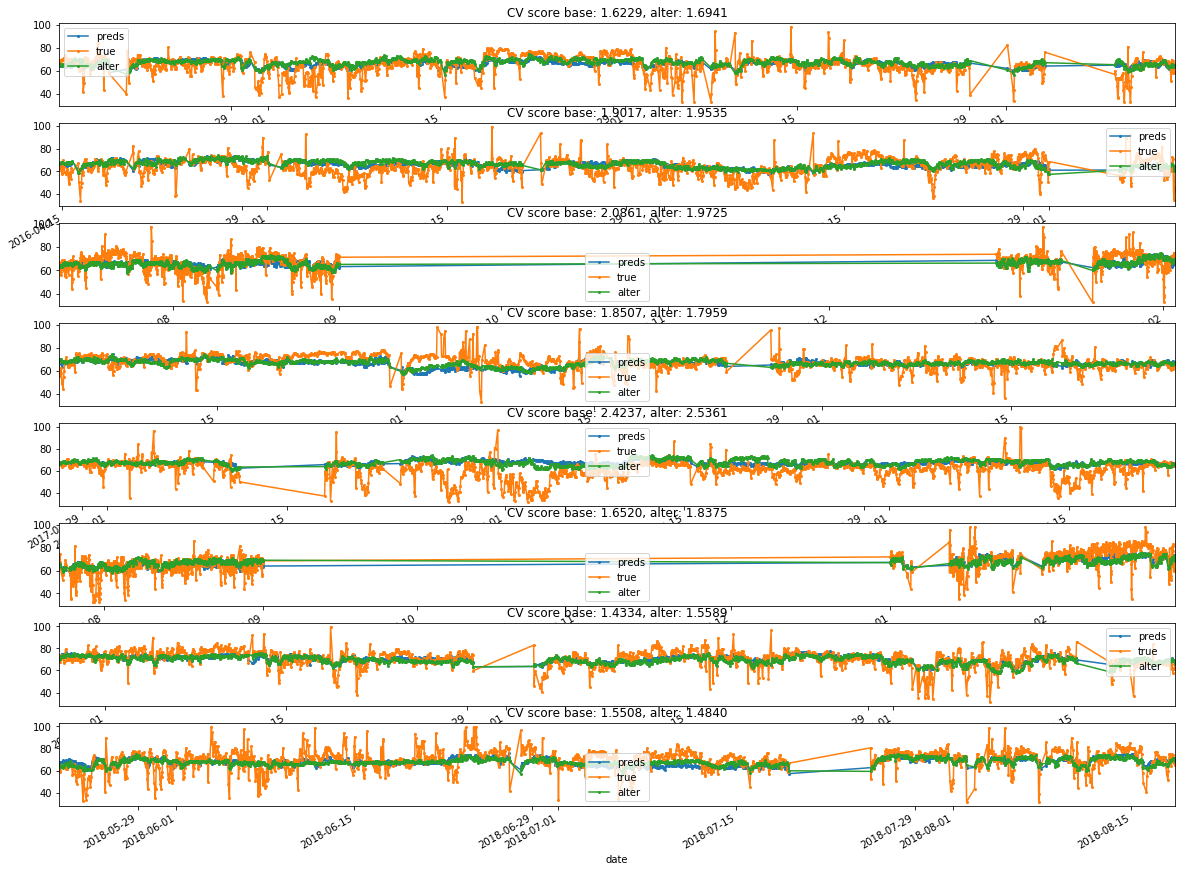

In [71]:
rmsle_cv_gen_compare(model_lgb_sc,plot = True,X_base=X,X_alt = X_alt,y=y,catboost = False)

In [50]:
lower_y = np.linspace(1,20,10)
lgb_a =  lgb.LGBMRegressor(objective='huber',
                              learning_rate=0.07, n_estimators=500,random_state=8,
                              **{'max_depth': 4, 'num_leaves': 63, 'feature_fraction': '0.879', 'bagging_fraction': '0.727'})

weights = ((y > 0) & (y < 100)).astype(float)
scores_with_outl,preds_with_outl = cv_oof(lgb_a,X_base = X,y=y,params = {'sample_weight':weights})
print(f'Baseline score: {scores_with_outl}')
for yt in lower_y:
    
    print(f'{yt}')
    weights = ((y > 0) & (y < 100-yt)).astype(float)
    scores_no_outl,preds_no_outl = cv_oof(lgb_a,X_base = X,y=y,params = {'sample_weight':weights})
    print(f'After outlier removal score: {scores_no_outl}')



Baseline score: 2.3056187011050375
1.0
After outlier removal score: 2.306714631874784
3.111111111111111
After outlier removal score: 2.319186154516676
5.222222222222222
After outlier removal score: 2.3615677064524427
7.333333333333334
After outlier removal score: 2.418798827006547
9.444444444444445
After outlier removal score: 2.5618603015886934
11.555555555555555
After outlier removal score: 2.8076030042884406
13.666666666666668
After outlier removal score: 3.042713794425597
15.777777777777779
After outlier removal score: 3.5326643118412897
17.88888888888889
After outlier removal score: 4.104960130829434
20.0
After outlier removal score: 4.788831902416656


In [48]:

for th in np.linspace(prob_irf.min(),prob_irf.max(),20):
    df['predict'] = df['predict_with_outlier']
    ind = df['classification'] >= th
    df.loc[ind, 'predict'] = df.loc[ind, 'predict_no_outlier']
    print(mase( df['predict'],y))

1.6787283826067207
1.6787674640164174
1.678819048494696
1.6787345381897514
1.6784398496643378
1.6782693380882363
1.6780843465743116
1.6778689070533388
1.678034424967285
1.677578351137256
1.6777563389752195
1.6774056942354378
1.674481178268453
1.67032607310833
1.6694996664402415
1.6691918504628476
1.671068410815507
1.671758819644184
1.6726655636965577
1.6728769945834197


# Test catboost here

(4504,)
0:	learn: 40.6047323	test: 39.4613920	best: 39.4613920 (0)	total: 26.1ms	remaining: 1m 5s
100:	learn: 32.7299325	test: 31.6400526	best: 31.6400526 (100)	total: 1.66s	remaining: 39.4s
200:	learn: 24.8214325	test: 23.7324600	best: 23.7324600 (200)	total: 2.57s	remaining: 29.4s
300:	learn: 16.9130000	test: 15.8249334	best: 15.8249334 (300)	total: 3.5s	remaining: 25.6s
400:	learn: 9.2364971	test: 8.2181559	best: 8.2181559 (400)	total: 4.8s	remaining: 25.1s
500:	learn: 3.5848549	test: 3.0525078	best: 3.0525078 (500)	total: 7.41s	remaining: 29.6s
600:	learn: 2.0195373	test: 2.0610850	best: 2.0576053 (599)	total: 10.1s	remaining: 31.8s
bestTest = 2.010776012
bestIteration = 662
Shrink model to first 663 iterations.
(4504,)
0:	learn: 40.7590713	test: 38.3806547	best: 38.3806547 (0)	total: 17.6ms	remaining: 44s
100:	learn: 32.8856136	test: 30.5332343	best: 30.5332343 (100)	total: 1.68s	remaining: 40s
200:	learn: 24.9771136	test: 22.6294353	best: 22.6294353 (200)	total: 2.6s	remaining: 2

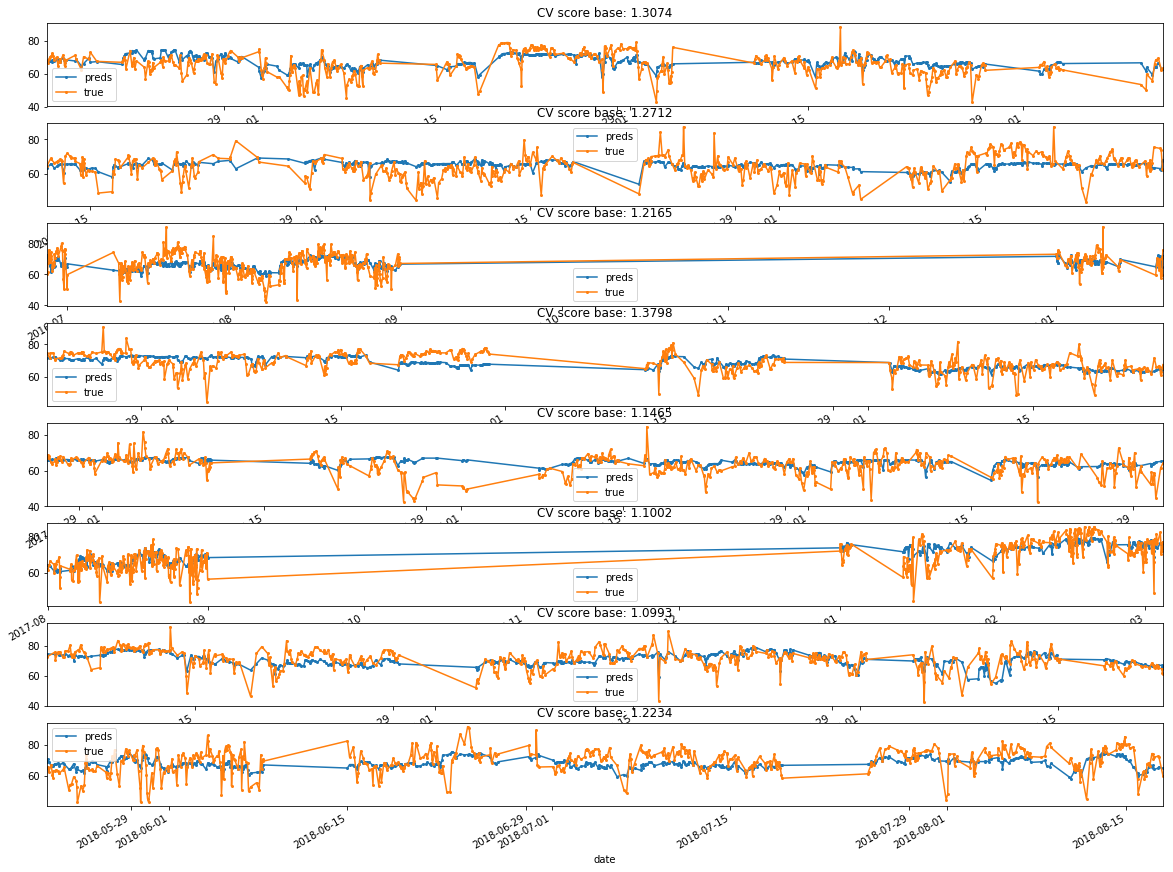

In [83]:
n_folds =8
class CustomMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes - list of list-like objects (one object per approx dimension)
        # target - list-like object
        # weight - list-like object, can be None
        error_sum = mase(approxes[0],target)
        return error_sum,0
def rmsle_cv_gen_cat(model,cv = None,plot = False,X_base=None,y=None,catboost = False):
    if cv is None:
        cv = KFold(n_folds, shuffle=False, random_state=42)
    scores = []
    preds_all_alt = np.empty_like(y)
    preds_all_base = np.empty_like(y)
    
    true_all =np.empty_like(y)
    if plot:
        fig,ax = plt.subplots(figsize = (20,16),nrows = n_folds)
    for fold_n, (train_index, valid_index) in enumerate(cv.split(X)):
    # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        print(y.shape)
        # Do the base
        if not catboost:
            model.fit(X_train.values,y_train.values.reshape(-1,))
        else:
            model.fit(X_train.values,y_train.values.reshape(-1,),eval_set=(X_valid.values, y_valid.values.reshape(-1,)),plot=False,verbose_eval = 100)
                
        preds  = model.predict(X_valid.values)
        preds_all_base[valid_index] = preds
        score_val = mase(preds,y_valid)
        true_all[valid_index] = y_valid
        scores.append(score_val)
        if plot:
            df = pd.DataFrame({"preds":preds,"true":y_valid})
            df.plot(ax=ax[fold_n],style =['-o','-o'],title =f'CV score base: {score_val:.4f}',markersize=2)
    
    #print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    oof_scores = {"base":mase(preds_all_base,true_all)}
    print(oof_scores)
    if plot:
        return(ax,np.array(scores),oof_scores)
    else:
        return(np.array(scores),oof_scores)
    
CatBoost = CatBoostRegressor(loss_function='Quantile:alpha=0.6',random_seed =123,eta=0.22,max_depth=6,task_type='GPU',od_type = 'Iter',
                             od_wait= 25,iterations = 2500,has_time = True)#eval_metric = CustomMetric())

ax,score,oof_scores = rmsle_cv_gen_cat(CatBoost,plot=True,X_base=X,y=y,catboost=True)
# Quantile:0.55 is the best so far

In [38]:
tgt = 'rougher.output.recovery'
year = 2019
X = data_dict[year]['X_train_tsclean']
y = data_dict[year]['y_train_tsclean']
inds_y = y[(y[tgt] > 35) & (y[tgt] < 100)].indexddd
inds_common = inds_y
X = X.loc[inds_common,]
y = y.loc[inds_common,]
X=X.join(y)

X.to_csv('../data/interim/cleaned.csv')

C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Test the RollingWindow CV

date
2016-07-11 04:59:59+00:00    56.1618
Name: final.output.recovery, dtype: float64
date
2016-07-19 04:59:59+00:00    75.440777
Name: final.output.recovery, dtype: float64
date
2016-07-28 02:59:59+00:00    100.0
Name: final.output.recovery, dtype: float64
date
2016-08-06 19:59:59+00:00    43.697826
Name: final.output.recovery, dtype: float64
date
2016-08-14 07:59:59+00:00    66.580549
Name: final.output.recovery, dtype: float64
date
2016-08-22 03:59:59+00:00    69.741038
Name: final.output.recovery, dtype: float64
date
2016-08-31 22:59:59+00:00    66.180583
Name: final.output.recovery, dtype: float64


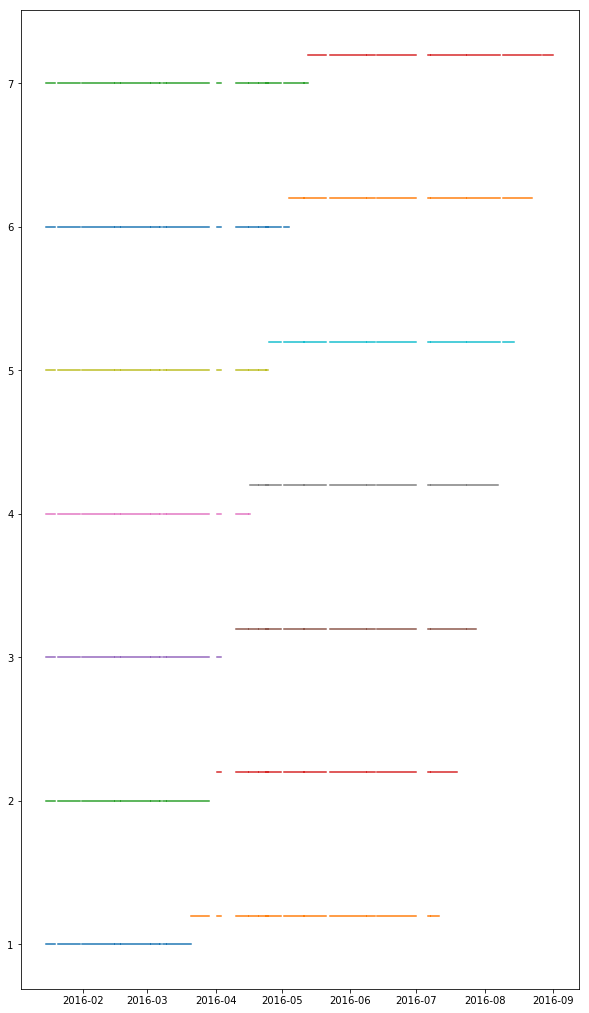

In [14]:
year = 2016
X = data_dict[year]['X_train']
y = data_dict[year]['y_train']['final.output.recovery']
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import numpy as np
 
class TimeSeriesSplitImproved(TimeSeriesSplit):
    
    def split(self, X, y=None, groups=None, fixed_length=False,
              train_splits=5, test_splits=6):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        fixed_length : bool, hether training sets should always have
            common length
        train_splits : positive int, for the minimum number of
            splits to include in training sets
        test_splits : positive int, for the number of splits to
            include in the test set
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        train_splits, test_splits = int(train_splits), int(test_splits)
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater than the number of samples: {1}.").format(n_folds,n_samples))
        
        indices = np.arange(n_samples)
        split_size = (n_samples // n_folds)
        test_size = split_size * test_splits
        train_size = split_size * train_splits
        test_starts = range(train_size + n_samples % n_folds,
                            n_samples - (test_size - split_size),
                            split_size)
        if fixed_length:
            for i, test_start in zip(range(len(test_starts)),
                                     test_starts):
                rem = 0
                if i == 0:
                    rem = n_samples % n_folds
                yield (indices[(test_start - train_size - rem):test_start],
                       indices[test_start:test_start + test_size])
        else:
            for test_start in test_starts:
                yield (indices[:test_start],
                    indices[test_start:test_start + test_size])
Nmonths_total = 8
Nspl = int(Nmonths_total * 30 / 10)
Nmonths_test = 4
Nmonths_min_train = 2.5
cv_ts = TimeSeriesSplitImproved(n_splits = Nspl)
train_splits = Nspl // Nmonths_total*Nmonths_min_train
test_splits=int(Nmonths_test / Nmonths_total*Nspl)
k=0
tt = pd.DataFrame()
X = X.sample(frac=0.3).sort_index()
y= y[X.index]
fig,ax = plt.subplots(figsize = (10,18))
for n,(train_index, test_index) in enumerate(cv_ts.split(X,fixed_length = False,train_splits = train_splits,test_splits = test_splits )):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(y_test.tail(1))
    k+=1
    ax.plot(y_train.index,(y_train*0+k))                
    ax.plot(y_test.index,(y_test*0+k+0.2))
    #ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


In [85]:
a =pd.DataFrame(y)
a['daily_avg'] = a.groupby(a.index.day)['final.output.recovery'].transform('mean')
a

,final.output.recovery,daily_avg
date,,
2016-01-15 01:00:00+00:00,69.266198,67.828885
2016-01-15 02:00:00+00:00,68.116445,67.828885
2016-01-15 03:00:00+00:00,68.347543,67.828885
2016-01-15 04:00:00+00:00,66.927016,67.828885
2016-01-15 05:00:00+00:00,69.465816,67.828885
2016-01-15 06:00:00+00:00,69.300835,67.828885
2016-01-15 07:00:00+00:00,70.230976,67.828885
2016-01-15 08:00:00+00:00,69.688595,67.828885
2016-01-15 09:00:00+00:00,70.279619,67.828885


In [76]:
test_splits

24

In [77]:
Nspl


48

In [66]:
8*30/10


24.0

In [ ]:
X.sort()